Import all the libraries.

In [1]:
import pandas as pd
import janitor
#from matplotlib import pyplot as plt
#import matplotlib.dates as mdates
#from matplotlib.dates import DateFormatter
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
#pio.renderers.default = "notebook_connected"
#pio.renderers.default = "svg"

Get the data.

In [2]:
ppa_price = pd.read_csv('/Users/katiepress/Desktop/Rproj/Tidy Tuesday/ppa_price.csv')

Check out the first few rows of the dataframe. Identical to head() in R. 

In [3]:
ppa_price.head()

,PPA Execution Date,Capacity (MW),CAISO,West (non-ISO),MISO,SPP,ERCOT,PJM,NYISO,ISO-NE,Southeast (non-ISO),Hawaii
0,2006-09-01T00:00:00Z,7.0,NaN,239.87343,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2007-06-25T00:00:00Z,5.0,220.631414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2008-07-01T00:00:00Z,550.0,150.730405,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2008-07-23T00:00:00Z,210.0,131.770690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2008-12-19T00:00:00Z,10.0,168.787932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Check out the column types. In R you could use str(ppa_price). 

In [4]:
ppa_price.dtypes

PPA Execution Date      object
Capacity (MW)          float64
CAISO                  float64
West (non-ISO)         float64
MISO                   float64
SPP                    float64
ERCOT                  float64
PJM                    float64
NYISO                  float64
ISO-NE                 float64
Southeast (non-ISO)    float64
Hawaii                 float64
dtype: object

The data is of course in wide format, so I need to gather it into long format. The pd.melt function seems similar to tidyverse::pivot_longer, but when I checked the documentation it didn't look like there was a way to drop the NAs. 

In [5]:
ppa_price_long = pd.melt(
    ppa_price,
    id_vars=['PPA Execution Date', 'Capacity (MW)'],
    var_name='region',
    value_name='price'
)

So the result is what would happen if I used gather() or didn't specify values_drop_na in pivot_longer. It did what I wanted, I just need an extra step to filter out the NAs. 

In [6]:
ppa_price_long.head()

,PPA Execution Date,Capacity (MW),region,price
0,2006-09-01T00:00:00Z,7.0,CAISO,NaN
1,2007-06-25T00:00:00Z,5.0,CAISO,220.631414
2,2008-07-01T00:00:00Z,550.0,CAISO,150.730405
3,2008-07-23T00:00:00Z,210.0,CAISO,131.770690
4,2008-12-19T00:00:00Z,10.0,CAISO,168.787932


There are only two column names that need to be cleaned, but I was happy to see that pyjanitor is available so I can use my beloved clean-names() function in Python as well, I'm going to go ahead and use that. Side note - it was very confusing to install pyjanitor and then not be able to import it, I finally figured out through googling that it's just called janitor when imported?

Clean the column names. 

In [7]:
ppa_price_long = janitor.clean_names(ppa_price_long)

Double check that everything worked as expected. 

In [8]:
ppa_price_long.columns

Index(['ppa_execution_date', 'capacity_mw_', 'region', 'price'], dtype='object')

Not sure why "capacity_mw_" has an extra underscore so I guess I'll fix that. Just changing one column name here but you could use this to rename several columns at once. 

In [9]:
ppa_price_long = ppa_price_long.rename(columns={"capacity_mw_" : "capacity_mw"})

Now drop the NAs after the fact, which gives me 333 rows, same as what I had in R. 

In [10]:
ppa_price_long = ppa_price_long.dropna()

Creating a year variable for aggregation later. First I had to convert the ppa_execution_date to datetime format, even though it kind of looked like it was formatted correctly. 

In [11]:
ppa_price_long['ppa_execution_date'] = pd.to_datetime(ppa_price_long['ppa_execution_date'])
ppa_price_long['ppa_year'] = ppa_price_long['ppa_execution_date'].dt.year

Python's categorical seems similar to R's factor variable. Changing the region to categorical and putting it in alphabetical order for the plots. 

In [12]:
ppa_price_long['region_cat'] = pd.Categorical(ppa_price_long['region'], ordered=True)

Check the min and max values of capacity for mapping to the size scale. 

In [13]:
ppa_price_long['capacity_mw'].agg([min, max])

min      3.6
max    550.0
Name: capacity_mw, dtype: float64

I like this colormap function since I often want to map specific colors to variables. I'm still using tableau colors here to try and match to the dashboard. 

In [14]:
sns.set_style("whitegrid")

colormap = {"CAISO": "#4E79A7", "ERCOT": "#F28E2B", "Hawaii": "#E15759", "ISO-NE": "#76B7B2",
"MISO": "#59A14F", "NYISO": "#BAB0AC", "PJM": "#9C755F", "Southeast (non-ISO)": "#FF9DA7",
"SPP": "#B07AA1", "West (non-ISO)": "#EDC948"}

This is my first attempt at a bubble chart in seaborn. It's not terrible, but the legend was a bit hard to deal with. I wanted to remove the size legend and put the color legend on the top or the bottom of the chart. 

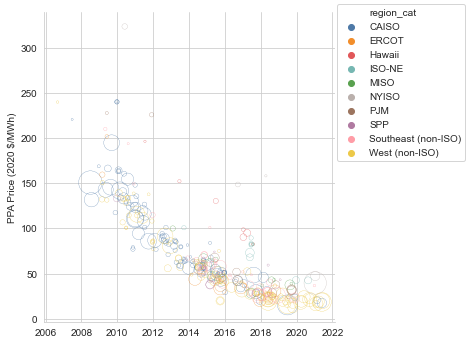

In [15]:
p = sns.relplot(data=ppa_price_long, 
    x="ppa_execution_date", 
    y = "price", 
    size = "capacity_mw", 
    hue = "region_cat",
    palette = colormap,
    ec=ppa_price_long["region_cat"].map(colormap),
    fc="none",
    sizes = (3, 550))

p.set(xlabel=None, ylabel="PPA Price (2020 $/MWh)")

p.legend.remove()
p.fig.legend(handles=p.legend.legendHandles[:11])

I looked at the stacked bar plots for Seaborn, and there is not a great way to do them in this package. I wanted to try and do it all in Seaborn but that isn't working out very well (how do they NOT have stacked bar functions???). I will have to switch to Plotly. 

At least with plotly (see below) I was able to deal with the legend pretty easily. I am somewhat familiar with this from R and using it in Shiny dashboards, but I use ggplot2 in R about 95% of the time. 

In [16]:
fig2 = px.scatter(ppa_price_long,
 x='ppa_execution_date',
 y='price',
 template = "plotly_white",
 labels = dict(region_cat = "Region",
               ppa_execution_date = "", 
               price = "PPA Price (2020 $/MWh)"),
 size='capacity_mw',
 color='region_cat',
 color_discrete_map=colormap)

fig2.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="left",
    x=0
))

fig2.update_traces(marker_symbol='circle-open', 
marker_line_width = 2)


fig2.show()

Now for the bar chart. I need to aggregate the data using groupby(). Looks like the reset_index() is necessary to make sure the variables stay in their own columns. 

In [17]:
ppa_capacity = ppa_price_long.groupby(['region_cat', 'ppa_year'])['capacity_mw'].sum().reset_index()

Arrange the table so that it will be in the right order for the chart since apparently they appear in the same order as the dataframe, even if it's a factor? 

In [18]:
test_ppa = ppa_capacity.sort_values(by='region_cat', ascending=False)

Final bar chart looks pretty good. The only thing I don't love about this is I couldn't figure out a way to split up the legend so that it was two rows with five columns like I had in R. Or at least, I couldn't find a way to do that quickly. I also had to specify all the years for the x-axis, since not all of them showed up the first time I plotted it. I think it was only every other year, even though they all fit. It was a little bit difficult to figure out how to annotate the bars with yearly totals, but there isn't a super great way to do that in ggplot2 either, I just know all the ggplot2 hacks from using it all the time. 

In [20]:
fig3 = px.bar(test_ppa,
             x='ppa_year',
             y='capacity_mw',
             labels = dict(region_cat = "Region",
                           ppa_year = "", 
                           capacity_mw = "Capacity (MW-AC)"),
             color='region_cat',
             color_discrete_map=colormap, 
             template = "plotly_white")

fig3.update_layout(legend_traceorder="reversed",
                  legend_title_text="Region",
                  legend = dict(orientation='h', 
                  yanchor='bottom',
                  y = 1.02,
                  xanchor='left',
                  x=0))


fig3.update_layout(
    annotations=[
        {"x": x, "y": total + 100, "text": str(total), "showarrow": False}
        for x, total in ppa_capacity.groupby("ppa_year", as_index=False).agg({"capacity_mw": "sum"}).values.astype(int)
    ]
)

fig3.update_xaxes(tickvals=[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
                           2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

fig3.show("notebook")

And after all that, I tried to find a good way to put these plots together one on top of the other like I did with ggarrange(). Of course there was no easy way to do that. But if I had used a different plotting function than plotly express, maybe? I will have to investigate this further. Overall, I was able to recreate the plots and most of the aesthetic specifications in Python, which was the main point of this. 